# Steam (Environment - Agent)

In [1]:
# Basic import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import norm
import pdb
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Concatenate
from tensorflow.keras.models import Model
tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.0.0


## Environment

In [2]:
class Environment:
    def __init__(self, nb_films, nb_users, 
                 context_size = 2,
                 displayed_users_embedding_size = 2, #used for the features vector
                 displayed_games_embedding_size = 2, #used for the features vector
                 noise_size = 3,
                 rating_probability = 0.5,
                 std_dev_playtime = 0.15,
                 seed=None):     
        self._rng = np.random.RandomState(seed)
        self._rating_probability = rating_probability 
        self._std_dev_playtime = std_dev_playtime
        #-------------------------------------------------------#
        self._nb_games = nb_games
        self._nb_users = nb_users
        self._p = context_size # size of user, size of game
        self._displayed_users_embedding_size = displayed_users_embedding_size
        self._displayed_games_embedding_size = displayed_games_embedding_size
        self._noise_size = noise_size
        #-------------------------------------------------------
        self.user_mean = np.ones(self._p)
        self.user_var = np.ones(self._p)
        self.game_mean = np.ones(self._p)
        self.game_var = np.ones(self._p)
        #-------------------------------------------------------#
        self.finish = False # True = all games have been played
    
    def step(self):
        if self.finish == True or self._available_games.sum() == 0: 
            # all players played all games
            self.finish = True
            print("All games played reset the environment")
            return 0, 0, self.finish
        
        user = self.get_next_user() # pick a user
        available_games = np.where(self._available_games[user] == 1)[0]
        optimal_reward = np.max(self._reward_matrix[user,available_games])
        return user, available_games, optimal_reward, self.finish
    
    def get_next_user(self):
        user = self._rng.randint(0, self._nb_users)
        if np.sum(self._available_games[user,:]) > 0: 
            # still some games to play for user
            return user
        else: 
            # all games played for the current user
            # find a random player between the ones who have some games left to play
            row,cols = np.where(self._available_games == 1)
            return self._rng.choice(row)
    
    def update(self, user, game):
        # rate the game w/ probability = self._rating_probability
        if np.random.binomial(1, self._rating_probability):
            reward = self._reward_matrix[user, game]
        else:
            reward = -1
        # in any case, store the time spent playing the game
        # for simulation purposes, such playtime (always >= 0) is based on the similarity 
        # between the user profile and the game (i.e. like a reward) + some noise
        playtime = np.searchsorted(self.z_cut_points, self._users[user].dot(self._games[game])) / 4
        playtime += self._rng.normal(loc = 0.0, scale = self._std_dev_playtime)
        playtime = np.clip(np.abs(playtime), 0, 1)
        self._playtime[user, game] = playtime
        
        self._available_games[user, game] = 0
        return reward, self._playtime[user, game]
    
    def reset(self):
        self.finish = False
        self._users = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self._nb_users, self._p))
        self._games = self._rng.normal(loc=self.game_mean,
                                                scale=self.game_var,
                                                size=(self._nb_games, self._p))
        
        z_mean = self.user_mean.dot(self.game_mean)
        z_var = self.user_var.dot(self.game_var) + self.user_var.dot(np.square(self.game_mean)) + \
                self.game_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        self.z_cut_points = z.ppf([0.2, 0.4, 0.6, 0.8]) # buckets
        
        # reward generation based on (user ∙ game)
        self._available_games = np.ones((nb_users, nb_games))
        self._playtime = np.zeros((nb_users, nb_games))
        self._reward_matrix = np.zeros((nb_users, nb_games))     
        for i in range(self._reward_matrix.shape[0]):
            for j in range(self._reward_matrix.shape[1]):
                real_score = self._users[i].dot(self._games[j])
                self._reward_matrix[i, j] = np.searchsorted(self.z_cut_points, real_score) / 4

        users = deepcopy(self._users)
        return users

    def get_feature_vector(self, user, game):
        user_embedding = self._users[user]
        game_embedding = self._games[game]
        
        if self._displayed_users_embedding_size + self._displayed_games_embedding_size > 0:
            variables = np.array([user_embedding[:self._displayed_users_embedding_size],
                                  game_embedding[:self._displayed_games_embedding_size]])

            if self._noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self._noise_size),
                                         scale=np.ones(self._noise_size),
                                         size=self._noise_size)
                
                variables = np.append(variables, noise)
                
        return variables
        
        
    def reset_seed(self, seed=None):
        self._rng = np.random.RandomState(seed)
        return

## Random agent

In [3]:
class RandomAgent:
    def __init__(self, seed = None):
        self._rng = np.random.RandomState(seed)
    
    def act(self, available_games):
        action = self._rng.choice(available_games)
        return action

## Experiment

In [4]:
# Basic parameter
nb_users = 30 #number of users in the context = 30
nb_games = 10 #number of games in the context = 10
context_size = 2 #number of different film categories = 2

In [5]:
# Creating the environment
env = Environment(nb_games,nb_users,context_size,seed=2020,rating_probability=0.7)
env.reset() #reset and initilize the environment

array([[-0.76884571,  1.07555227],
       [-0.1306297 ,  0.34856983],
       [ 0.10688437, -0.27410098],
       [ 0.93884557,  1.06451384],
       [ 1.41011295,  0.42711751],
       [ 0.19866638,  2.31203519],
       [ 2.27469887, -0.2143576 ],
       [ 1.31371941, -0.44482142],
       [ 0.6310387 ,  0.23077342],
       [ 1.3926161 ,  1.05729383],
       [ 3.08997884,  1.04197131],
       [ 0.95165928,  0.48684608],
       [ 0.91541072, -0.21545008],
       [-0.41293073, -0.48691055],
       [ 1.38222486,  1.937673  ],
       [ 2.77267804,  1.87882801],
       [ 1.33171912,  0.69396433],
       [ 2.24026615,  0.78437316],
       [ 1.15592948,  1.09805553],
       [ 1.83209585,  3.04520542],
       [ 0.68318608, -0.31283291],
       [-0.75445746,  1.10209408],
       [-0.36150208,  1.48178488],
       [ 0.79167126,  0.90813649],
       [ 1.70268816,  1.10365506],
       [ 1.62123638,  1.95411497],
       [ 3.03781352,  0.51554878],
       [ 1.2071549 ,  2.64424216],
       [ 0.5117926 ,

In [6]:
# Creating the agent
agent = RandomAgent(2020)

We run the experiment and generate some historical data.

In [7]:
# Running several trials
nb_iteration = 100 #how many trials
rating_matrix = np.zeros((env._nb_users, env._nb_games))
playtime_matrix = np.zeros((env._nb_users, env._nb_games))
users = list()
games = list()
ratings = list()
for i in range(nb_iteration):
    user, available_games, _, finish = env.step()
    if finish:
        print("Maybe too many trial try to reduce and reset the environment")
        break
    choosen_game = agent.act(available_games)
    reward, playtime = env.update(user, choosen_game)
    users.append(user)
    games.append(choosen_game)
    ratings.append(reward)
    rating_matrix[user, choosen_game] = reward
    playtime_matrix[user, choosen_game] = playtime
    '''
    print("user = {}, recommended_games = {}, choosen_game = {}".format(user,recommended_games,choosen_game))
    print("reward = {}\n".format(reward))
    '''
print("rating matrix: \n", str(rating_matrix))
print("playtime: \n", str(np.int8(playtime_matrix * 100)))

rating matrix: 
 [[ 0.    0.    0.   -1.    0.    0.    0.25  0.25  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -1.    0.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.25  0.5   0.    0.   -1.    0.    0.    0.    0.    0.  ]
 [ 0.25  0.    0.    0.    1.    0.    0.    0.    0.5   0.  ]
 [ 0.    0.   -1.   -1.    0.25  0.    0.    0.    0.   -1.  ]
 [ 0.    0.5   0.   -1.    0.    0.    0.    0.5   0.    0.  ]
 [ 0.    0.   -1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.25  0.25  0.   -1.    0.    0.    0.    0.25  0.25]
 [ 0.    0.    0.    0.25  1.    0.    0.   -1.    0.    0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.    0.    0.    0.5   0.    0.  ]
 [ 0.   -1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.5   0.    0.   -1.    0.75  1.    0.25]
 [ 0.5   0.    0.    0.   -1.    0.   

In [8]:
# threshold for asking for refund
threshold = 0.1

rewards = list()
for i in range(len(users)):
    u_idx = users[i]
    g_idx = games[i]
    if playtime_matrix[u_idx, g_idx] < threshold:
        rewards.append(playtime_matrix[u_idx, g_idx])
    else:
        if ratings[i] >= 0.0:
            rewards.append(ratings[i])
        else:
            r = playtime_matrix[u_idx, g_idx] / np.sum(playtime_matrix[u_idx, :])
            rewards.append(r)
print("rating list: \n", ratings)
print("actual rewards: \n", rewards)

rating list: 
 [-1, 0.5, -1, 0.0, 0.0, -1, -1, -1, 0.5, 0.25, 0.25, -1, 0.5, 0.5, -1, 0.0, 0.25, 0.25, 0.25, 0.25, 1.0, 0.0, -1, 0.5, -1, 0.5, 0.0, 0.5, 0.25, 0.75, 1.0, 0.0, 0.25, 1.0, -1, -1, -1, -1, 1.0, -1, -1, 0.0, 0.0, 0.25, 0.25, 0.25, 0.5, 0.25, 1.0, 0.5, -1, 0.25, -1, 0.0, -1, 0.5, 0.75, 0.25, -1, -1, -1, 0.25, 0.25, -1, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, -1, 0.0, 0.5, 0.25, -1, -1, 0.5, 0.75, 0.5, -1, 0.0, 0.5, 1.0, 0.75, 0.0, 0.0, 0.5, 1.0, 0.25, 0.25, 0.25, 0.75, -1, 0.5, 1.0, 0.75, 0.25, -1]
actual rewards: 
 [0.07289535621949804, 0.5, 0.638082516467091, 0.03526072639067718, 0.045508212862360856, 0.09032895645498558, 0.23930773764186972, 0.45637410891991276, 0.5, 0.25, 0.25, 0.23735439544759793, 0.5, 0.5, 1.0, 0.0, 0.07597726551114567, 0.25, 0.25, 0.25, 1.0, 0.0, 0.2918787889116293, 0.5, 0.7819374799999025, 0.5, 0.07514973559796664, 0.5, 0.25, 0.75, 1.0, 0.019031738477175184, 0.25, 1.0, 0.07281487492439079, 0.3108084110146919, 0.23930773764186972, 0.513849570461

## Regression model

In [9]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        y = self.dot([user_vecs, game_vecs])
        return y

## Deep regression model

In [10]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dropout = Dropout(0.9)
        self.dense1 = Dense(16, activation="relu")
        self.dense2 = Dense(8, activation="tanh")
        
    def call(self, inputs, training=False):
        featureVector = True
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        feature_inputs = inputs[2]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        if featureVector:
            input_vecs = self.concat([user_vecs, game_vecs, self.flatten(feature_inputs)])
        else:
            input_vecs = self.concat([user_vecs, game_vecs])
        
        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dense2(y)
        
        return y

## Embedding agent

In [11]:
class EmbeddingAgent:
    def __init__(self, X, Y, deepRegression=False):
        if deepRegression:
            self._model = DeepRegressionModel(64, nb_users, nb_games)
        else:
            self._model = RegressionModel(64, nb_users, nb_games)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(X, Y,
                  batch_size=64, epochs=100, validation_split=0.1,
                  shuffle=True)
        self._user_embeddings = self._model.get_weights()[0]
        self._game_embeddings = self._model.get_weights()[1]
    
    def act(self, user, available_games):
        user_embedding = self._user_embeddings[user]
        dot_products = self._game_embeddings @ user_embedding
        user_embedding_norm = np.linalg.norm(user_embedding)
        all_item_norms = np.linalg.norm(self._game_embeddings, axis=1)
        norm_products = user_embedding_norm * all_item_norms
        sims = dot_products / (norm_products)
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]

In [12]:
deepRegression = False

users = np.array(users)
games = np.array(games)
ratings = np.array(ratings)

if deepRegression:
    features = []
    for i in range(len(users)):
        features.append(env.get_feature_vector(users[i], games[i]))
    features = np.float64(features)
    agent = EmbeddingAgent([users, games, features], ratings, deepRegression=deepRegression)
else:
    agent = EmbeddingAgent([users, games], ratings, deepRegression=deepRegression)

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 0s 488us/sample - loss: 0.5648 - val_loss: 0.6002
Epoch 2/100
90/90 [==============================] - 0s 366us/sample - loss: 0.5627 - val_loss: 0.6004
Epoch 3/100
90/90 [==============================] - 0s 442us/sample - loss: 0.5609 - val_loss: 0.6006
Epoch 4/100
90/90 [==============================] - 0s 433us/sample - loss: 0.5592 - val_loss: 0.6008
Epoch 5/100
90/90 [==============================] - 0s 390us/sample - loss: 0.5576 - val_loss: 0.6010
Epoch 6/100
90/90 [==============================] - 0s 436us/sample - loss: 0.5559 - val_loss: 0.6011
Epoch 7/100
90/90 [==============================] - 0s 388us/sample - loss: 0.5542 - val_loss: 0.6013
Epoch 8/100
90/90 [==============================] - 0s 405us/sample - loss: 0.5525 - val_loss: 0.6014
Epoch 9/100
90/90 [==============================] - 0s 392us/sample - loss: 0.5508 - val_loss: 0.6016
Epoch 10/100
90/90 [=========

90/90 [==============================] - 0s 410us/sample - loss: 0.1193 - val_loss: 0.5697
Epoch 80/100
90/90 [==============================] - 0s 389us/sample - loss: 0.1148 - val_loss: 0.5690
Epoch 81/100
90/90 [==============================] - 0s 370us/sample - loss: 0.1092 - val_loss: 0.5683
Epoch 82/100
90/90 [==============================] - 0s 367us/sample - loss: 0.1041 - val_loss: 0.5679
Epoch 83/100
90/90 [==============================] - 0s 374us/sample - loss: 0.0998 - val_loss: 0.5681
Epoch 84/100
90/90 [==============================] - 0s 356us/sample - loss: 0.0953 - val_loss: 0.5686
Epoch 85/100
90/90 [==============================] - 0s 363us/sample - loss: 0.0910 - val_loss: 0.5688
Epoch 86/100
90/90 [==============================] - 0s 365us/sample - loss: 0.0855 - val_loss: 0.5691
Epoch 87/100
90/90 [==============================] - 0s 368us/sample - loss: 0.0804 - val_loss: 0.5694
Epoch 88/100
90/90 [==============================] - 0s 363us/sample - loss:

In [13]:
prev_env = deepcopy(env)

In [14]:
nb_iteration = 100
nb_exp = 100
#---------------#
regret = np.zeros(nb_exp)
cum_regret = np.zeros((nb_exp, nb_iteration))

for t in range(nb_exp):
    env = deepcopy(prev_env)
    env.reset_seed()
    regrets = np.zeros(nb_iteration)
    for i in range(nb_iteration):
        user, available_games, optimal_reward, finish = env.step()
        if finish:
            print("Maybe too many trial try to reduce and reset the environment")
            break
        choosen_game = agent.act(user, available_games)
        reward, _ = env.update(user, choosen_game)
        regrets[i] = optimal_reward - reward
        # print("user = {}, available games = {}, choosen_game = {}".format(user,available_games,choosen_game))
        # print("reward = {}\n".format(reward))
    cum_regret[t] = np.cumsum(regrets)
    regret[t] = np.sum(regrets)

## Measuring performances

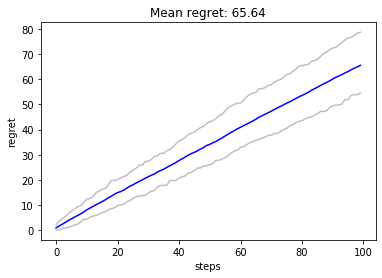

In [15]:
plt.plot(cum_regret.mean(axis=0), color='blue')
plt.plot(np.quantile(cum_regret, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(cum_regret, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()